### To explore how timestep affects SIR spreading
>We first do a simple observation: look at how s/i/r - t plot changes as we increase dt

In [36]:
import networkx as nx
import operator #standard python library used for sorting
from tqdm import tqdm
import random
from timing import timeit
from fileload import load_matfile
import matplotlib.pyplot as plt
import numpy as np

In [37]:
G_blogcatalog = load_matfile(file_ = "blogcatalog.mat",unDirected=True)

In [38]:
State = {'susceptible': 0, 
         'infectious' : 1, 
         'removed'    : 2}


def reset(G):
    '''
    set all nodes' state as 'susceptible'
    '''
    nx.set_node_attributes(G, name = 'state', values = State['susceptible'])
    
def nodes_sorted(G, sort_by_attribute = "degree"):
    '''
    return sort nodes by attribute e.g. degree/betweenness
    '''
    if sort_by_attribute == "degree":
        node_attributes = dict(G.degree())
    elif sort_by_attribute == "betweenness":
        node_attributes = dict(nx.betweenness_centrality(G))
    sorted_nodes = dict(sorted(node_attributes.items(), key=operator.itemgetter(1), reverse=True))
    return sorted_nodes

def set_seeds(G, num_seeds, set_seeds_by = "degree"):
    '''
    select seeds by random or degree,
    set seeds' state as infected
    '''
    if set_seeds_by == "degree":
        seeds = list(nodes_sorted(G, sort_by_attribute="degree").keys())[0:num_seeds]
    elif set_seeds_by == "random":
        seeds = random.sample(list(G.nodes), num_seeds)
        
    for seed in seeds:
        G.node[seed]['state'] = State['infectious']
    return seeds

In [39]:
def model_factory(beta, alpha, r, mu):
    '''
    model_atomic updates states all at once;
    model_non_atomic updates states one by one
    return a SIR spreading simulation model
    '''
    def model(n, G):
        neighbors_to_infect = []
        RemoveMyself = False
        if G.node[n]['state'] == State['infectious']:
            susceptible_neighbors = [k for k in G.neighbors(n) if G.node[k]['state']==State['susceptible']]
            # rand_nums[-1] is to sample recover time
            rand_nums = np.random.random(len(susceptible_neighbors)+1)
            recover_flag = rand_nums[-1]**(r/mu)
            if rand_nums[-1] < alpha:
                RemoveMyself = True
            neighbors_to_infect += [k for i,k in enumerate(susceptible_neighbors) if rand_nums[i] > recover_flag]
#             for k in susceptible_neighbors:
#                 if random.random() < beta:
#                     neighbors_to_infect.append(k)
#             if random.random() < alpha:
#                 RemoveMyself = True
            
            
        return neighbors_to_infect, RemoveMyself
    
    return model
        

def one_epoch(G, model):
    '''
    add all nodes to be infected to nodes_to_infect,
    add all nodes to be removed to nodes_to_remove,
    and update their states all at once
    '''
    nodes_to_infect = []
    nodes_to_remove = []
    for n in G:
        neighbors_to_infect, RemoveMyself = model(n, G)
        nodes_to_infect += neighbors_to_infect
        nodes_to_remove += [n] if RemoveMyself else []
        
    for n in nodes_to_infect:
        G.node[n]['state'] = State['infectious']
    for n in nodes_to_remove:
        G.node[n]['state'] = State['removed']
    
def get_states(G):
    susceptible_nodes = []
    infected_nodes = []
    removed_nodes = []
    for n in G:
        state = G.node[n]['state']
        if state == State['susceptible']:
            susceptible_nodes.append(n)
        elif state == State['infectious']:
            infected_nodes.append(n)
        elif state == State['removed']:
            removed_nodes.append(n)
    return susceptible_nodes, infected_nodes, removed_nodes

@timeit
def spread(G, model):
    ss, ii, rr = [], [], []
    i = 1 # anything > 0 to enter the loop below
    while(i > 0):
        susceptible_nodes, infected_nodes, removed_nodes = get_states(G)
        i = len(infected_nodes)
        print('\r num_infectious_nodes:         %d' % (i),end="")
        ss.append(len(susceptible_nodes))
        ii.append(i)
        rr.append(len(removed_nodes))
        one_epoch(G, model)
        
    return ss, ii, rr



 num_infectious_nodes:         0'spread'  17566.36 ms


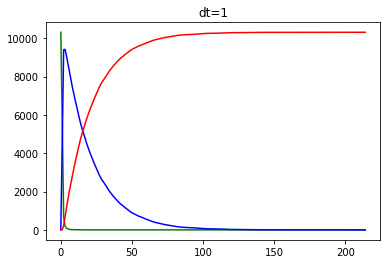

 num_infectious_nodes:         0'spread'  10821.70 ms


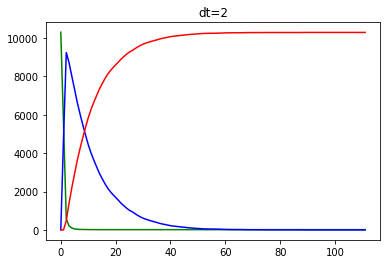

 num_infectious_nodes:         0'spread'  5225.68 ms


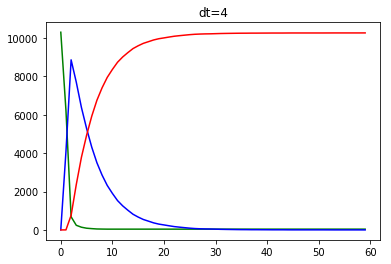

 num_infectious_nodes:         0'spread'  3089.16 ms


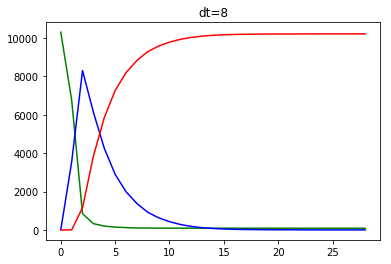

 num_infectious_nodes:         0'spread'  1763.64 ms


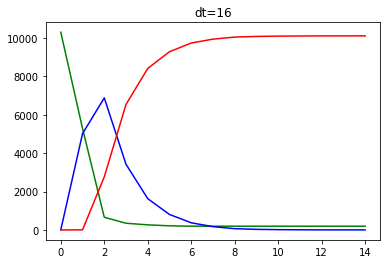

 num_infectious_nodes:         0'spread'  1248.68 ms


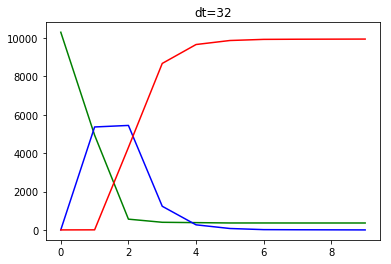

 num_infectious_nodes:         0'spread'  1044.33 ms


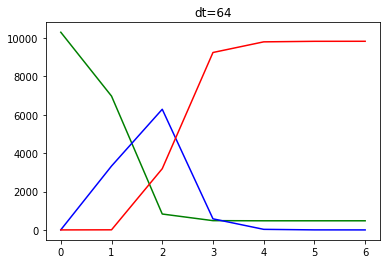

In [43]:
# G_FB = nx.read_edgelist("NOLAfacebook.csv", create_using=nx.Graph(), delimiter=",", nodetype=int)
# print("Graph readed!")

for i,dt in enumerate([1,2,4,8,16,32,64]):
    reset(G_blogcatalog)
    r = 0.03
    mu = 0.05
    beta = 1-np.exp(-r*dt)
    alpha = 1-np.exp(-mu*dt)
    set_seeds(G=G_blogcatalog, num_seeds=5, set_seeds_by="degree")
    model = model_factory(beta, alpha, r, mu)
    ss, ii, rr = spread(G_blogcatalog, model)

#     fig_size= [9,6]
#     plt.rcParams.update({'font.size': 14, "figure.figsize": fig_size})
    xvalues = range(len(ss))
    plt.figure(i)
    plt.plot(xvalues, ss, color='g', linestyle='-', label="S")
    plt.plot(xvalues, ii, color='b', linestyle='-', label="I")
    plt.plot(xvalues, rr, color='r', linestyle='-', label="R")
    plt.title("dt="+str(dt))
#     plt.xlim(0,200)
    plt.show()

### P(at least A->B, B->C happened in dt)/P(at least A->B happened in dt): $\frac{r}{r+\mu}-\frac{r*dt}{e^{(r+\mu)*dt}-1}$

Text(0,0.5,'relative probability of 2 infections in dt')

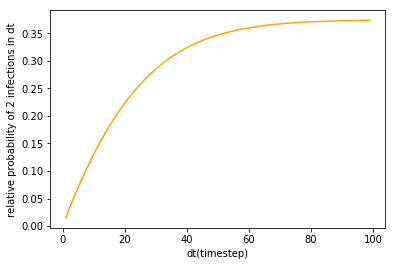

In [35]:
import matplotlib.pyplot as plt
import numpy as np
def ratio(dt, r=0.03, mu=0.05):
    return r/(r+mu)-r*dt/(np.exp((r+mu)*dt)-1)

pp = []
for dt in range(1,100):
    pp.append(ratio(dt))
    
plt.plot(list(range(1,100)),pp,'orange')
plt.xlabel("dt(timestep)")
plt.ylabel("relative probability of 2 infections in dt")

### P(at least an infection happen before recover in dt) = $\frac{r}{r+\mu}(1-e^{-(r+\mu)*dt})$

> as timestep increases, the case approximate the situation in which percolating that starts from seeds

> all the infection orders are lost, but final numbers of recovered nodes are always the same.

Text(0,0.5,'at least an infection happen before recover')

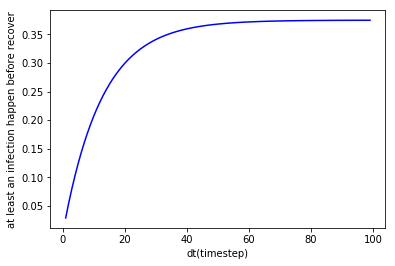

In [45]:
def p_infect_in_dt(dt, r=0.03, mu=0.05):
    return r/(r+mu)*(1-np.exp(-(r+mu)*dt))

p_infect_list = []
for dt in range(1,100):
    p_infect_list.append(p_infect_in_dt(dt))
    
plt.plot(list(range(1,100)),p_infect_list, 'b')
plt.xlabel("dt(timestep)")
plt.ylabel("at least an infection happen before recover")